In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
import hydra
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()
# setup hydra config global for loading this notebook
hydra.initialize(config_path="configs", version_base=None)
cfg = hydra.compose(config_name="config")


In [3]:
from main import setup_environment, get_checkpoint_info, is_training_complete

# Setup environment
device = setup_environment(cfg)

# Get checkpoint info
output_dir, checkpoint = get_checkpoint_info(cfg, num_epochs=cfg.training.num_epochs)

# Instantiate everything
bridge = hydra.utils.instantiate(cfg.bridge)
dataset = hydra.utils.instantiate(cfg.dataset)
model = hydra.utils.instantiate(cfg.model)
model.load_state_dict(checkpoint['model_state_dict'])
    

05:10:41 - INFO - Using device: cuda
05:10:43 - INFO - Using compile: False
05:10:44 - INFO - Found checkpoint: /orcd/data/omarabu/001/njwfish/counting_flows/outputs/f97a6f93c454/model.pt


Pre-sampling 50000 samples with d=5, r=3, k=5...
✓ Pre-sampling complete!
in_dims: [5, 1, 100]
total_input_dim: 106
out_dim: [5]
total_output_dim: 5


/home/njwfish/miniconda3/envs/sc/lib/python3.10/site-packages/torch/random.py:187: UserWarning: CUDA reports that you have 8 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)


<All keys matched successfully>

In [12]:
import cupy as cp
x0_hat = bridge.sampler(x_1=x_1, z={}, model=model.cuda())

In [13]:
model.cuda().forward({'x_1': torch.tensor(dataset.x1_data).cuda(), 't': torch.ones(dataset.x1_data.shape[0], 1).cuda()}).var(dim=0)

/tmp/ipykernel_1721551/2058403612.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.cuda().forward({'x_1': torch.tensor(dataset.x1_data).cuda(), 't': torch.ones(dataset.x1_data.shape[0], 1).cuda()}).var(dim=0)


tensor([28.2720, 31.8347, 18.1671, 32.7049, 90.1704], device='cuda:0',
       grad_fn=<VarBackward0>)

In [228]:
import torch
x_0 = dataset.x0_data.cuda()
x_1 = dataset.x1_data.cuda()

base_idx = -100
n_samples = 1_000_000
x_1 = x_1[base_idx].unsqueeze(0).expand(n_samples, -1)
x_0 = x_0[base_idx].unsqueeze(0).expand(n_samples, -1)

class OracleModel(torch.nn.Module):
    def __init__(self, x_0):
        super().__init__()
        self.x_0 = torch.nn.Parameter(x_0, requires_grad=False)

    def forward(self, x):
        return self.x_0

    def sample(self, **kwargs):
        return self.x_0

oracle_model = OracleModel(x_0)


In [229]:
x0_hat, x_t_traj, x_0_traj = bridge.sampler(x_1=x_1, z={}, model=oracle_model.cuda(), return_trajectory=True, return_x_hat=True)
x_t_traj = x_t_traj.cpu().numpy()

In [230]:
import numpy as np
marginal_traj = np.flip(cp.stack([cp.from_dlpack(x_0)] + [cp.from_dlpack(bridge(x_1=x_1, x_0=x_0, t=t)[1]) for t in cp.linspace(0, 1, 10 + 1)[1:-1]] + [cp.from_dlpack(x_1)]).get(), axis=0)

In [226]:
x_t_traj.shape, marginal_traj.shape

((11, 100000, 5), (11, 100000, 5))

In [232]:
x_t_traj = x_t_traj.astype(np.float64)
marginal_traj = marginal_traj.astype(np.float64)

In [233]:
np.abs(x_t_traj.mean(axis=1) - marginal_traj.mean(axis=1)).max(), np.abs(x_t_traj.var(axis=1) - marginal_traj.var(axis=1)).max()

(np.float64(0.009475000000009004), np.float64(0.13458578753573036))

In [227]:
np.abs(x_t_traj.mean(axis=1) - marginal_traj.mean(axis=1)).max(), np.abs(x_t_traj.var(axis=1) - marginal_traj.var(axis=1)).max()

(np.float64(0.3207550048828125), np.float64(0.2843270016699613))

In [205]:
np.mean(x_t_traj.var(axis=1) < marginal_traj.var(axis=1))

np.float64(0.4909090909090909)

In [202]:
(x_t_traj.mean(axis=1) - marginal_traj.mean(axis=1)).argmax()

np.int64(28)

In [203]:
marginal_traj.shape

(11, 1000000, 5)

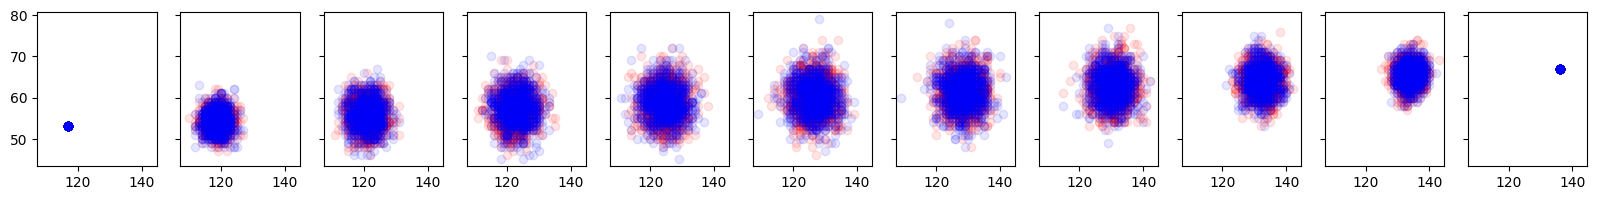

In [204]:
# plot the marginal trajectory at time t against the x_t_traj at time t

import matplotlib.pyplot as plt
max_to_plot = 1_000
x_axis_idx = 1
y_axis_idx = 2
fig, axs = plt.subplots(1, 11, figsize=(20, 2), sharex=True, sharey=True)
for i in range(11):
    axs[i].scatter(marginal_traj[i][:max_to_plot, x_axis_idx], marginal_traj[i][:max_to_plot, y_axis_idx], alpha=0.1, color='red')
    axs[i].scatter(x_t_traj[i][:max_to_plot, x_axis_idx], x_t_traj[i][:max_to_plot, y_axis_idx], alpha=0.1, color='blue')
plt.show()


In [158]:
(x_01 - x_01.mean(dim=0)).T @ (x_01 - x_01.mean(dim=0)) / (100_000 - 1)

tensor([[ 1.6397e+01,  2.2541e-02,  2.4508e-02, -2.5334e-03,  7.3768e-02],
        [ 2.2541e-02,  5.9426e+00,  2.6186e-03,  1.5800e-02,  1.4130e-02],
        [ 2.4508e-02,  2.6186e-03,  6.1418e+00,  1.4924e-02,  3.9562e-03],
        [-2.5334e-03,  1.5800e-02,  1.4924e-02,  5.6896e+00,  1.8413e-02],
        [ 7.3768e-02,  1.4130e-02,  3.9562e-03,  1.8413e-02,  5.8052e+00]],
       device='cuda:0')

In [ ]:
import torch
torch.var(x0_hat)

tensor(5600.3325, device='cuda:0')

In [32]:
x0_hat.float().var(dim=0)

tensor([35.2421, 40.1347, 16.8753, 33.8740, 96.6934], device='cuda:0')

In [30]:
cp.array(dataset.x0_data).var(axis=0)

array([29.24722689, 36.91947904, 17.37493323, 34.87880703, 90.45091671])

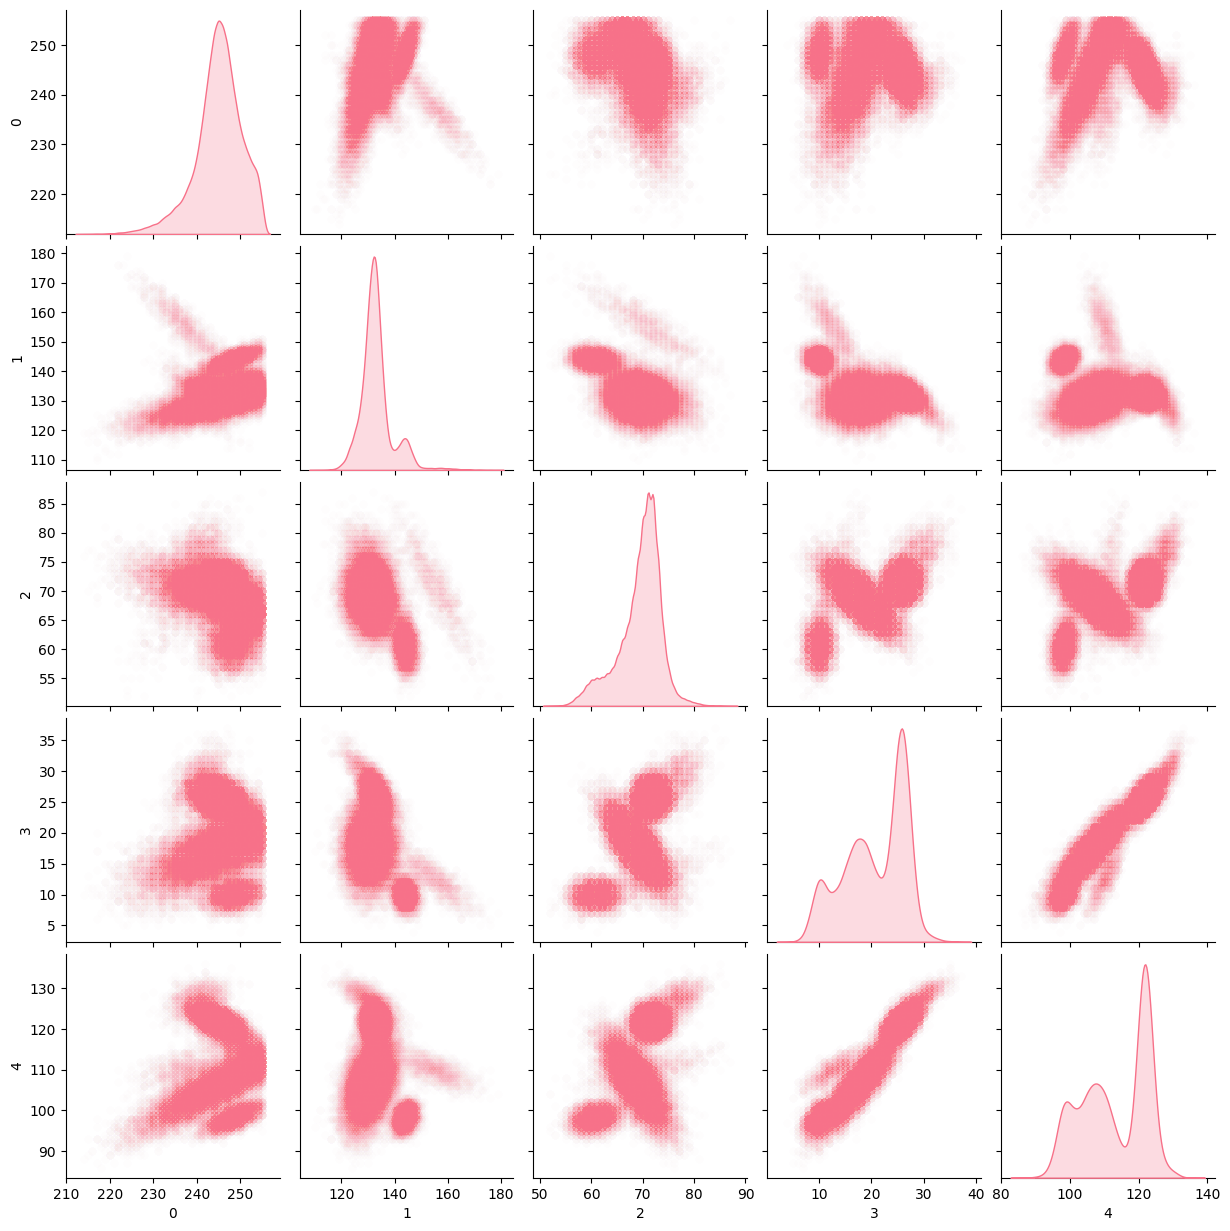

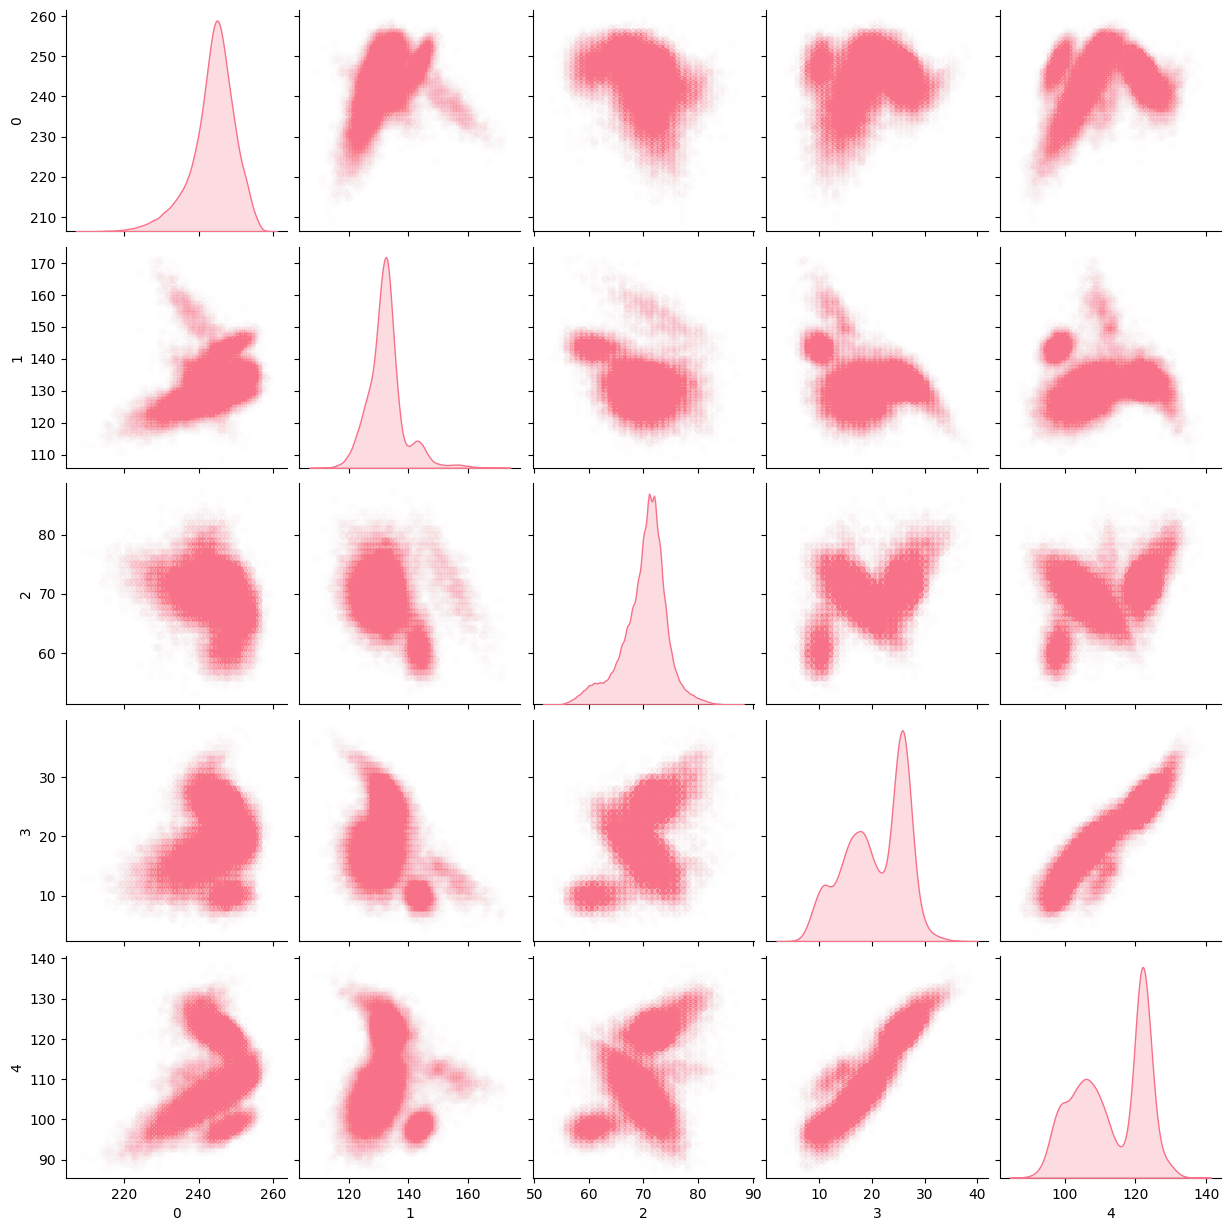

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df_true = pd.DataFrame(dataset.x0_data.cpu().numpy())
df_true['type'] = 'true'
df_hat = pd.DataFrame(x0_hat.cpu().numpy())
df_hat['type'] = 'hat'
df = pd.concat([df_true, df_hat])

sns.pairplot(df_true, kind='scatter', plot_kws={'alpha': 0.01}, diag_kind='kde')
sns.pairplot(df_hat, kind='scatter', plot_kws={'alpha': 0.01}, diag_kind='kde')
plt.show()